# Introduction to Data Science Assignment

In this assignment we look at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. 

(Originally a Kaggle Competition: https://www.kaggle.com/c/higgs-boson)
***

### Part 1: Data preparation 


In [1]:
import pandas as pd
from sklearn.preprocessing import scale
import numpy as np
def cleanBosonData(infile_name):
    data_clean = pd.DataFrame(pd.read_csv(infile_name))
    data_clean = data_clean.set_index('EventId', drop=True)
    
    Y = [int(i == 's') for i in data_clean['Label']]
    data_clean['Y'] = Y
    data_clean = data_clean.drop(['Label'], axis=1)   
    
    col_index = data_clean.columns.values
    sec_col_index = data_clean.drop('Y', 1).columns.values
    
    missingv_df = data_clean.mask(data_clean == -999, 1)
    missingv_df.columns = [col_index[k] + '_mv' for k in range(len(col_index))]
    missingv_df = missingv_df.mask(missingv_df != 1, 0)
    
    data_clean = data_clean.replace(-999, np.NaN)
    data_clean = data_clean.fillna(data_clean.mean())
    
    scl_data = pd.DataFrame(scale(data_clean, 0))
    scl_data.columns = col_index
    scl_data = scl_data.set_index(data_clean.index)
    
    scl_data['Y'] = [int(j > 1) for j in scl_data['Y']]
    return scl_data

### Part 2: Basic evaluations 

1\. Clean the two data files included in this assignment (`data/boson_training_cut_2000.csv` and `data/boson_testing_cut.csv`) by using the function defined above, and use them as training and testing data sets.

In [2]:
data_train = cleanBosonData('C:/Users/Samsung9/Desktop/NYUMSDS/Fall2017/IntroductiontoDataScience/Assignments/boson_training_cut_2000.csv')
data_test = cleanBosonData('C:/Users/Samsung9/Desktop/NYUMSDS/Fall2017/IntroductiontoDataScience/Assignments/boson_testing_cut.csv')

2\. On the training set, build the SVM and the LR:

For each model above, plot the ROC curve of both models on the same plot. 

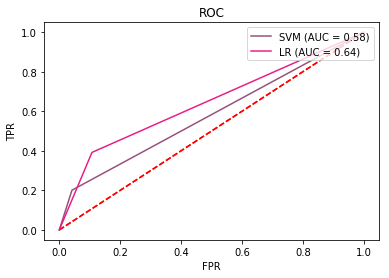

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from collections import defaultdict

Y_train = data_train['Y']
X_train = data_train.drop(['Y'], 1)

lr = LogisticRegression(C=1e30) ## why?
lr.fit(X_train, Y_train, sample_weight=None)

svm = SVC(kernel='linear')
svm.fit(X_train, Y_train)

Y_test = data_test['Y']
X_test = data_test.drop(['Y'], 1)

lr_prd = lr.predict(X_test)
svm_prd = svm.predict(X_test)

def plotROC(true_array, prediction, label_str):
    fpr, tpr, thresholds = roc_curve(true_array, prediction)
    roc_auc = auc(fpr, tpr)
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    
    plt.plot([0, 1], [0, 1], 'k--', color='red')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    
    return plt.plot(fpr, tpr, color=c, label= label_str+' (AUC = %0.2f)' % roc_auc)

svmplot = plotROC(Y_test, svm_prd, 'SVM') 
logregplot = plotROC(Y_test, lr_prd, 'LR')
plt.legend(loc=1)


### Part 3: Model selection with cross-validation 
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 2000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function 

In [4]:
from sklearn.cross_validation import KFold
from collections import defaultdict

def xValSVM(dataset, label_name, k, cs):
    aucs_df = pd.DataFrame(columns=np.arange(k), index=10.0**np.arange(-8, 2, 1))
    kf = KFold(len(dataset[dataset.columns[0]]), k)
    AUC_c_k_dict = defaultdict(list)
    fold = 0 
    
    for train_ix, validate_ix in kf:
        cv_validate = dataset[:][validate_ix[0]:validate_ix[-1]]
        cv_train = dataset.drop(dataset.index[validate_ix[0]:validate_ix[-1]])
        X_train = cv_train.drop(['Y'], 1)
        X_val = cv_validate.drop(['Y'], 1)
        Y_train = cv_train['Y']
        Y_val = cv_validate['Y']

        for c in cs: 
            svm = SVC(C=c, kernel='linear')
            svm.fit(X_train, Y_train)
            fpr, tpr, thresholds = roc_curve(Y_val.values.ravel(), svm.predict(X_val))
            
            roc_auc = auc(fpr, tpr)
            aucs_df.loc[c, fold] = roc_auc
            
            AUC_c_k_dict[c] = [roc_auc_fold for roc_auc_fold in aucs_df.T[c]]
            
        fold = fold + 1
 
    return AUC_c_k_dict

xValSVM(data_train, label_name='Y', k=10, cs=10.00**(np.arange(-8, 2, 1)))

C:\Users\Samsung9\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


defaultdict(list,
            {1e-08: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
             9.9999999999999995e-08: [0.5,
              0.5,
              0.5,
              0.5,
              0.5,
              0.5,
              0.5,
              0.5,
              0.5,
              0.5],
             9.9999999999999995e-07: [0.5,
              0.5,
              0.5,
              0.5,
              0.5,
              0.5,
              0.5,
              0.5,
              0.5,
              0.5],
             1.0000000000000001e-05: [0.5,
              0.5,
              0.5,
              0.5,
              0.5,
              0.5,
              0.5,
              0.5,
              0.5,
              0.5],
             0.0001: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
             0.001: [0.50441488109253585,
              0.50657894736842102,
              0.49629629629629629,
              0.50657894736842102,
              0.50724637681159424,
          

2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1, inclusive).
2.	Call aucs = xValSVM(data_train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) (don't forget, standard error of the mean of X is sqrt(Var(X)/N)
4.	Compute the value for max_1std = (mean(AUC)-StdErr(AUC)) associated with the c having max(mean(AUC)). I.e., part of what we have been calling the '1 standard error rule'.
5.	Generate a plot with the following:
    -	Log10(c) on the x-axis
    -	1 series with mean(AUC) for each c
    -	1 series with mean(AUC)-2*stderr(AUC) for each c (use ‘k+’ as color pattern)
    -	1 series with mean(AUC)+2*stderr(AUC) for each c (use ‘k--‘ as color pattern)
    -	a reference line for max_1std (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 

In [5]:
def xValSVM(dataset, label_name, k, cs):
    aucs_df = pd.DataFrame(columns=np.arange(k), index=10.0**np.arange(-8, 2, 1))
    kf = KFold(len(dataset[dataset.columns[0]]), k)
   
    fold = 0 
    
    for train_ix, validate_ix in kf:
        cv_validate = dataset[:][validate_ix[0]:validate_ix[-1]]
        cv_train = dataset.drop(dataset.index[validate_ix[0]:validate_ix[-1]])
        X_train = cv_train.drop(['Y'], 1)
        X_val = cv_validate.drop(['Y'], 1)
        Y_train = cv_train['Y']
        Y_val = cv_validate['Y']

        for c in cs: 
            svm = SVC(C=c, kernel='linear')
            svm.fit(X_train, Y_train)
            fpr, tpr, thresholds = roc_curve(Y_val.values.ravel(), svm.predict(X_val))
            
            roc_auc = auc(fpr, tpr)
            aucs_df.loc[c, fold] = roc_auc
            
        fold = fold + 1
 
    return aucs_df

xValSVM(data_train, label_name='Y', k=10, cs=10.00**(np.arange(-8, 2, 1)))

,0,1,2,3,4,5,6,7,8,9
1.000000e-08,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1.000000e-07,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1.000000e-06,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1.000000e-05,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1.000000e-04,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1.000000e-03,0.504415,0.506579,0.496296,0.506579,0.507246,0.519231,0.528302,0.504903,0.518182,0.514493
1.000000e-02,0.549152,0.537923,0.540278,0.54295,0.561371,0.566381,0.576376,0.525847,0.578346,0.532356
1.000000e-01,0.554332,0.533858,0.541088,0.554557,0.564771,0.581479,0.59098,0.556174,0.596528,0.571958
1.000000e+00,0.554332,0.547015,0.541088,0.561136,0.564771,0.581479,0.59014,0.556174,0.61471,0.571453
1.000000e+01,0.562397,0.54295,0.541088,0.561136,0.564771,0.581479,0.59014,0.556174,0.61471,0.571453


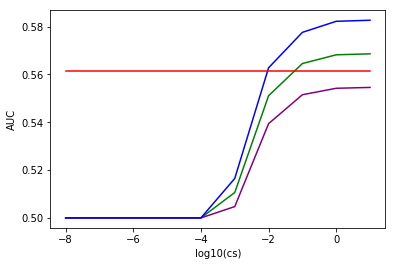

In [6]:
aucs_df = xValSVM(data_train, label_name='Y', k=10, cs=10.00**(np.arange(-8, 2, 1)))
aucs_df.mean(axis=1)
aucs_df.sem(axis=1)
aucs_df.mean(axis=1) - aucs_df.sem(axis=1)
max_lstd = max(aucs_df.mean(axis=1) - aucs_df.sem(axis=1))
max_lstd
cs = 10.00**np.arange(-8, 2, 1)
np.log10(cs)

plt.plot(np.log10(cs), aucs_df.mean(axis=1), color ='green')
plt.plot(np.log10(cs), aucs_df.mean(axis=1) - 2*(aucs_df.sem(axis=1)), color='purple')
plt.plot(np.log10(cs), aucs_df.mean(axis=1) + 2*(aucs_df.sem(axis=1)), color='blue')
plt.plot(np.log10(cs), np.repeat(max_lstd, 10), color='red')
plt.xlabel('log10(cs)')
plt.ylabel('AUC')
plt.show()

__Did the model parameters selected beat the out-of-the-box model for SVM?__

__Answer__ 

Yes, some parameters specified in the above model have beaten the out-of-the-box model for SVM. 

As we can see on the above DataFrame, if we set c to 10^0 or 10^1 (there is little difference in practice between these two), with 6-fold, 7-fold, and 9-fold cross validation we can beat the out-of-the-box SVM. 

### Part 4: Learning Curve with Bootstrapping (8 Points)

In this HW we are trying to find the best linear model to predict if a record represents the Higgs Boson. One of the drivers of the performance of a model is the sample size of the training set.  As a data scientist, sometimes you have to decide if you have enough data or if you should invest in more.  We can use learning curve analysis to determine if we have reached a performance plateau. This will inform us on whether or not we should invest in more data (in this case it would be by running more experiments).

Given a training set of size $N$, we test the performance of a model trained on a subsample of size $N_i$, where $N_i<=N$.  We can plot how performance grows as we move $N_i$ from $0$ to $N$.  

Because of the inherent randomness of subsamples of size $N_i$, we should expect that any single sample of size $N_i$ might not be representative of an algorithm’s performance at a given training set size. To quantify this variance and get a better generalization, we will also use bootstrap analysis. In bootstrap analysis, we pull multiple samples of size $N_i$, build a model, evaluate on a test set, and then take an average and standard error of the results.

An example of using bootstrapping to build a learning curve can be found here: https://github.com/briandalessandro/DataScienceCourse/blob/master/ipython/python35/Lecture_ERM_LogReg_3.ipynb


1\. Create a bootstrap function that can do the following:

def modBootstrapper(train, test, nruns, sampsize, lr, c):

-	Takes as input:
    -	A master training file (train)
    -	A master testing file (test)
    -	Number of bootstrap iterations (nruns) 
    -	Size of a bootstrap sample (sampsize)
    -	An indicator variable to specific LR or SVM (lr=1)
    -	A c option (only applicable to SVM)

-	Runs a loop with (nruns) iterations, and within each loop:
    -	Sample (sampsize) instances from train, with replacement
    -	Fit either an SVM or LR (depending on options specified). 
    -	Computes AUC on test data using predictions from model in above step
    -	Stores the AUC in a list

-	Returns the mean(AUC) and Standard Error(mean(AUC)) across all bootstrap samples. Note: the standard error of the mean AUC is really the standard deviation of the bootstrapped distribution, so just use np.sqrt(np.var(...))


In [11]:
def modBootstrapper(train, test, nruns, sampsize, lr, c):
    fpr = dict()
    tpr = dict()
#     roc_auc = dict()
    auc_list = []
    if lr == 1:
        s = 0
        for s in range(len(sampsize)):

            i = 0 
            for i in range(nruns): 
            
                sz = sampsize[s]
                train_samp = train.iloc[np.random.randint(0, len(train), size=sz)]
            
                Y_train = train_samp['Y']
                X_train = train_samp.drop(['Y'], 1)
            
                Y_test = test['Y']
                X_test = test.drop(['Y'], 1)

                lr_bootstr = LogisticRegression()
                lr_bootstr.fit(X_train, Y_train)
                lr_prd = lr_bootstr.predict(X_test) 
                
                fpr[s], tpr[s], thresholds = roc_curve(Y_test, lr_prd) 
                roc_auc = auc(fpr[s], tpr[s])

                auc_list.append(roc_auc)
                
        return auc_list
            
    elif lr == 0:
        s = 0
        for s in range(len(sampsize)):
            
            i = 0 
            for i in range(nruns):
            
                sz = sampsize[s]
                train_samp = train.iloc[np.random.randint(0, len(train), size=sz)]

                Y_train = train_samp['Y']
                X_train = train_samp.drop(['Y'], 1)

                Y_test = test['Y']
                X_test = test.drop(['Y'], 1)

                svm_bootstr = SVC(kernel='linear', C=1)
                svm_bootstr.fit(X_train, Y_train)
                svm_prd = svm_bootstr.predict(X_test)

                fpr[s], tpr[s], thresholds = roc_curve(Y_test, svm_prd) 
                roc_auc = auc(fpr[s], tpr[s])

                auc_list.append(roc_auc)

        return auc_list

lr_bootstr_auc = modBootstrapper(data_train, data_test, 20, sampsize = [50, 100, 200, 500, 1000, 1500, 2000], lr=1, c=None)
svm_bootstr_auc = modBootstrapper(data_train, data_test, 20, sampsize = [50, 100, 200, 500, 1000, 1500, 2000], lr=0, c=1)
# svm_bootstr_auc
# lr_bootstr_auc

[0.55737089481927948,
 0.67742781965433485,
 0.592170951068826,
 0.66416117336555747,
 0.69582579096719754,
 0.63131204193276558,
 0.59870170119213884,
 0.56810227482459408,
 0.51351575048610854,
 0.65664186689642723,
 0.56556253270168499,
 0.66808422845287108,
 0.56859911606988356,
 0.66943245154576425,
 0.59827632344402071,
 0.60040126038148334,
 0.66824366681449443,
 0.66561491625865865,
 0.64130403632833677,
 0.64717468840807135,
 0.62797065966497401,
 0.64587583883685484,
 0.63713905701765394,
 0.60568209263800243,
 0.62866608534517165,
 0.66544867320158396,
 0.66421217575566294,
 0.58427780243881022,
 0.65397033725193832,
 0.60849424881069236,
 0.64459741399819115,
 0.63729670593068211,
 0.587267104263412,
 0.66774908433773428,
 0.65967300473389801,
 0.5634231240312102,
 0.62985034100600101,
 0.63888444809318068,
 0.5877952834822906,
 0.56439507940423961,
 0.58453123254162009,
 0.64658382791891511,
 0.61222088773893613,
 0.6958428568240036,
 0.61831347580364127,
 0.61190559080006

2\. For both LR and SVM, run 20 bootstrap samples for each samplesize in the following list: samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]. (Note, this might take 10-15 mins … feel free to go grab a drink or watch Youtube while this runs). For SVM, use the value of C identified using the 1 standard error method from part 3. For LR, use the default C.

Generate a plot with the following:
-	Log2(samplesize) on the x-axis
-	2 sets of results lines, one for LR and one for SVM, the set should include
    -	1 series with mean(AUC) for each sampsize (use the color options ‘g’ for svm, ‘r’ for lr)
    -	1 series with mean(AUC)-stderr(AUC) for each samp size (use ‘+’ as color pattern, ‘g’,’r’ for SVM, LR respectively)
    -	1 series with mean(AUC)+stderr(AUC) for each samp size (use ‘--‘ as color pattern ‘g’,’r’ for SVM, LR respectively)


In [17]:
sampsize = [50, 100, 200, 500, 1000, 1500, 2000]
lr_auc_sampsize = [lr_bootstr_auc[j:j+20] for j in range (0, len(lr_bootstr_auc), 20)]
svm_auc_sampsize = [svm_bootstr_auc[j:j+20] for j in range(0, len(svm_bootstr_auc), 20)]

lr_auc_sampsize = pd.DataFrame(lr_auc_sampsize, index=sampsize, columns=[i for i in (np.arange(20)+1)])
# lr_auc_sampsize
svm_auc_sampsize = pd.DataFrame(svm_auc_sampsize, index=sampsize, columns=[i for i in (np.arange(20)+1)])
# svm_auc_sampsize

## On both DataFrames, rows are the sample sizes and column names are the corresponding iteration numbers. 

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
50,0.528878,0.674473,0.610174,0.672152,0.500000,0.688899,0.509307,0.562839,0.662680,0.571926,0.592648,0.632575,0.671099,0.596179,0.623289,0.559810,0.655716,0.647416,0.555004,0.546902
100,0.687015,0.691900,0.521863,0.694092,0.588217,0.624658,0.643713,0.555312,0.676706,0.651514,0.647956,0.555112,0.500000,0.599823,0.578054,0.500000,0.586132,0.574069,0.668680,0.661491
200,0.624467,0.554310,0.589816,0.565825,0.681426,0.673177,0.500000,0.559549,0.592100,0.667226,0.613027,0.588916,0.647487,0.681569,0.598372,0.661897,0.673920,0.500000,0.571675,0.675303
500,0.639356,0.557292,0.681389,0.681940,0.552061,0.602643,0.552727,0.670379,0.616730,0.561727,0.599816,0.594657,0.561372,0.633876,0.655328,0.672784,0.639712,0.600909,0.689841,0.566184
1000,0.660414,0.600486,0.592170,0.618784,0.584742,0.543182,0.568536,0.611482,0.582662,0.587178,0.584565,0.580048,0.554999,0.598968,0.661748,0.577053,0.587643,0.551279,0.574547,0.568289
1500,0.563174,0.584124,0.575961,0.574924,0.584384,0.578773,0.664133,0.567726,0.581482,0.598194,0.570376,0.584212,0.567936,0.545062,0.577336,0.569998,0.595273,0.586892,0.609475,0.584625
2000,0.625574,0.612901,0.580352,0.574842,0.578298,0.592512,0.600316,0.567016,0.577567,0.592339,0.567357,0.566254,0.554348,0.576309,0.575041,0.560600,0.595149,0.575662,0.565761,0.605196


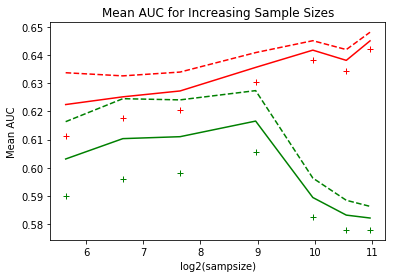

In [18]:
xs = np.log2(sampsize)

## LR - r
plt.plot(xs, lr_auc_sampsize.mean(axis=1), 'r')
plt.plot(xs, lr_auc_sampsize.mean(axis=1) - lr_auc_sampsize.sem(axis=1), 'r+')
plt.plot(xs, lr_auc_sampsize.mean(axis=1) + lr_auc_sampsize.sem(axis=1), 'r--')

## SVM - g
plt.plot(xs, svm_auc_sampsize.mean(axis=1), 'g')
plt.plot(xs, svm_auc_sampsize.mean(axis=1) - svm_auc_sampsize.sem(axis=1), 'g+')
plt.plot(xs, svm_auc_sampsize.mean(axis=1) + svm_auc_sampsize.sem(axis=1), 'g--')

plt.xlabel('log2(sampsize)') 
plt.ylabel('Mean AUC')
plt.title('Mean AUC for Increasing Sample Sizes')
plt.show()

3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?


__Answer__ 

Given the set of features, for smaller samples LR (plotted red) would be a better choice. 

The worth of doubling the data we have depends on:

   __1 The model that we choose to use.__ Logistic Regression tends to 'learn' better as we increase the sample size especially after sample size 512. However, SVM (plotted green) performs better in terms of AUC as we increase the number of samples until the same point (n=512). But then, its improvement stops. 
   
   __2) Our current sample size.__ We can interpret this given the set of features and our model choice. If we are using LR, doubling our sample size would not mean much if we have 50 or 100 samples. But given that we are using LR and wehave 200 or more samples, then doubling the sample size would be a worthy decision. On the other hand, if we are using SVM and we have 200 samples, doubling it would be a good decision. But after n=512, the AUC will decrease and it would be an unnecessary cost. 
   
   __3 Expected profit.__ Considering the two criteria above, we need to estimate the expected gain from doubling the sample size. If an increase in auc does result in a positive expected profit (that is, expected gain - cost of doubling the sample size), then increasing the number of samples is indeed the correct choice. 
   

4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased? (Hint: refer to ESL figure 7.8)?



__Answer__

Yes, cross validation might be biased since our sample size varies from 50 to 2000. While doing 10-fold cross validation on n=50, we will be training the model with n=45, but while the number of folds remains the same we will be training the model with n=1800 if the sampsize is set to 2000. Other than varying training set sizes, there is one domain-specific problem here. 

That is, even though we down-sample background instances, we already have a very small signal/background particle(#) ratio. There is a really high chance that we won't be able to find any signal instances among those 45 samples, therefore the model cannot be trained propely. However, as we increase the sample size, we are going to be able to capture the signal particles among the instances of the collision data more and more frequently, and as a result the model will be trained with 'better' data. 

For the reasons explained above, with smaller sample sizes, the model will tend to overestimate the prediction error, therefore the cross validation will be biased toward larger sample sizes. 